In [2]:
import tensorflow as tf
import numpy as np
import torch
import torchvision as tv
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
trainingSet = datasets.MNIST('', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
testingSet = datasets.MNIST('', train=False, download=False, transform=transforms.Compose([transforms.ToTensor()]))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



In [5]:
trainingSet

Dataset MNIST
    Number of datapoints: 60000
    Root location: 
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [7]:
batch_sizes = [64,1024]
train_loader1 = DataLoader(trainingSet, batch_size=batch_sizes[0], shuffle=True)
test_loader1 = DataLoader(testingSet, batch_size=batch_sizes[0], shuffle=True)

train_loader2 = DataLoader(trainingSet, batch_size=batch_sizes[1], shuffle=True)
test_loader2 = DataLoader(testingSet, batch_size=batch_sizes[1], shuffle=True)

In [8]:
def CalcParams(model):
    val = sum(params.numel() for params in model.parameters() if params.requires_grad)
    return val

In [9]:
class Model1(nn.Module):
    def __init__(self, in_features=784, h2=20, h3=40, out_features=10):
        super().__init__()
        self.fc1 = nn.Linear(in_features,h2)    
        self.fc2 = nn.Linear(h2, h3)
        self.out = nn.Linear(h3, out_features)
        
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [10]:
model1=Model1()
model1params=CalcParams(model1)
print(model1params)

16950


In [11]:
crit_loss1 = nn.CrossEntropyLoss()
optim1 = torch.optim.Adam(model1.parameters(), lr=0.001)

In [12]:
epochs = 10
train_correct_mod1 = []
test_correct_mod1 = []
train_losses_mod1=[]
test_losses_mod1=[]
for i in range(epochs):
    train_corr = 0
    test_corr = 0

    # training  the batches
    for b, (X_train, y_train) in enumerate(train_loader1):
       
        y_pred = model1(X_train.view(-1,784))  
        trn_loss = crit_loss1(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        train_corr += batch_corr
        
        # Update parameters
        optim1.zero_grad()
        trn_loss.backward()
        optim1.step()
        
    # Update train loss & accuracy for the epoch
    train_losses_mod1.append(trn_loss)
    train_correct_mod1.append(train_corr)
        
    # testing the batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader1):

            y_val = model1(X_test.view(-1,784)) 

            predicted = torch.max(y_val.data, 1)[1] 
            test_corr += (predicted == y_test).sum()
    # Update test loss & accuracy for the epoch
    test_loss = crit_loss1(y_val, y_test)
    test_losses_mod1.append(test_loss)
    test_correct_mod1.append(test_corr)            

In [13]:
train_loss_list=[]
for i in range(len(train_losses_mod1)):
     train_loss_list.append(train_losses_mod1[i].detach().numpy())


test_loss_list=[]
for i in range(len(test_losses_mod1)):
     test_loss_list.append(test_losses_mod1[i].detach().numpy())

train_accuracy_list=[]
for i in range(len(train_correct_mod1)):
     train_accuracy_list.append(train_correct_mod1[i].detach().numpy()/600)


test_accuracy_list=[]
for i in range(len(test_correct_mod1)):
     test_accuracy_list.append(test_correct_mod1[i].detach().numpy()/100)

     

In [14]:
#Model 2 with batch_size 1024
class Model2(nn.Module):
    def __init__(self, in_features=784, h2=20, h3=40, out_features=10):
        super().__init__()
        self.fc1 = nn.Linear(in_features,h2)    
        self.fc2 = nn.Linear(h2, h3)
        self.out = nn.Linear(h3, out_features)
        
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [15]:
model2=Model2()

In [16]:
model2params=CalcParams(model2)
print(model2params)
model2

16950


Model2(
  (fc1): Linear(in_features=784, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=40, bias=True)
  (out): Linear(in_features=40, out_features=10, bias=True)
)

In [17]:
crit_loss2 = nn.CrossEntropyLoss()
optim2 = torch.optim.Adam(model2.parameters(), lr=0.001)


In [18]:
epochs = 10
train_losses_mod2=[]
test_losses_mod2=[]
train_correct_mod2 = []
test_correct_mod2 = []
for i in range(epochs):
    train_corr = 0
    test_corr = 0

    # training  the batches
    for b, (X_train, y_train) in enumerate(train_loader2):
       
        y_pred = model2(X_train.view(-1,784))  
        loss = crit_loss2(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        train_corr += batch_corr
        
        # Update parameters
        optim2.zero_grad()
        loss.backward()
        optim2.step()
        
    # Update train loss & accuracy for the epoch
    train_losses_mod2.append(loss)
    train_correct_mod2.append(train_corr)
        
    # testing the batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader2):

            # Apply the model
            y_val = model2(X_test.view(-1,784)) 

            predicted = torch.max(y_val.data, 1)[1] 
            test_corr += (predicted == y_test).sum()
    # Update test loss & accuracy for the epoch
    loss = crit_loss2(y_val, y_test)
    test_losses_mod2.append(loss)
    test_correct_mod2.append(test_corr)            

In [19]:
for i in range(len(train_losses_mod2)):
     train_loss_list.append(train_losses_mod2[i].detach().numpy())

for i in range(len(test_losses_mod2)):
     test_loss_list.append(test_losses_mod2[i].detach().numpy())

for i in range(len(train_correct_mod2)):
     train_accuracy_list.append(train_correct_mod2[i].detach().numpy()/600)

for i in range(len(test_correct_mod2)):
     test_accuracy_list.append(test_correct_mod2[i].detach().numpy()/100)
     

In [20]:
alpa=np.linspace(-1.0, 2.0, num=20)
thetaArr=[]
for i in range(len(alpa)):
    theta=(1-alpa[i])*model1params+alpa[i]*model2params
    thetaArr.append(theta)

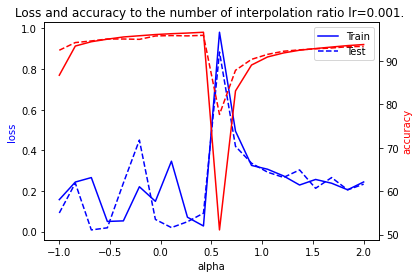

In [21]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(alpa, train_loss_list, 'b', label='Train')
ax1.plot(alpa, test_loss_list, 'b--', label='Test')
ax2.plot(alpa, train_accuracy_list, 'r', label='accuracy')
ax2.plot(alpa, test_accuracy_list, 'r--', label='accuracy')
ax1.set_title('Loss and accuracy to the number of interpolation ratio lr=0.001. ')
ax1.set_xlabel('alpha')
ax1.set_ylabel('loss', color='b')
ax2.set_ylabel('accuracy', color='r')
ax1.legend(loc='upper right')

In [22]:
class ModelOne(nn.Module):
    def __init__(self, in_features=784, h2=20, h3=40, out_features=10):
        super().__init__()
        self.fc1 = nn.Linear(in_features,h2)    
        self.fc2 = nn.Linear(h2, h3)
        self.out = nn.Linear(h3, out_features)
        
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [23]:
model_one=ModelOne()
crit_loss_one = nn.CrossEntropyLoss()
optim_one = torch.optim.Adam(model_one.parameters(), lr=0.01)


In [24]:
epochs = 10
train_correct_mod1 = []
test_correct_mod1 = []
train_losses_mod1=[]
test_losses_mod1=[]

for i in range(epochs):
    train_corr = 0
    test_corr = 0

    for b, (X_train, y_train) in enumerate(train_loader1):
       
        y_pred = model_one(X_train.view(-1,784))  
        trn_loss = crit_loss_one(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        train_corr += batch_corr
        
        # Update parameters
        optim_one.zero_grad()
        trn_loss.backward()
        optim_one.step()
        
    # Update train loss & accuracy for the epoch
    train_losses_mod1.append(trn_loss)
    train_correct_mod1.append(train_corr)
        
    # testing the batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader1):

            y_val = model_one(X_test.view(-1,784)) 

            predicted = torch.max(y_val.data, 1)[1] 
            test_corr += (predicted == y_test).sum()
    
    # Update test loss & accuracy for the epoch
    test_loss = crit_loss_one(y_val, y_test)
    test_losses_mod1.append(test_loss)
    test_correct_mod1.append(test_corr)

In [25]:
train_loss_list=[]
for i in range(len(train_losses_mod1)):
     train_loss_list.append(train_losses_mod1[i].detach().numpy())
test_loss_list=[]
for i in range(len(test_losses_mod1)):
     test_loss_list.append(test_losses_mod1[i].detach().numpy())

train_accuracy_list=[]
for i in range(len(train_correct_mod1)):
     train_accuracy_list.append(train_correct_mod1[i].detach().numpy()/600)
test_accuracy_list=[]
for i in range(len(test_correct_mod1)):
     test_accuracy_list.append(test_correct_mod1[i].detach().numpy()/100)
     
                    

In [26]:
#Model 2 with lr=0.01

class ModelTwo(nn.Module):
    def __init__(self, in_features=784, h2=20, h3=40, out_features=10):
        super().__init__()
        self.fc1 = nn.Linear(in_features,h2)    
        self.fc2 = nn.Linear(h2, h3)
        self.out = nn.Linear(h3, out_features)
        
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [27]:
model_two=ModelTwo()
crit_loss_two = nn.CrossEntropyLoss()
optim_two = torch.optim.Adam(model_two.parameters(), lr=0.01)

In [28]:
epochs = 10
train_correct_mod2 = []
test_correct_mod2 = []
train_losses_mod2=[]
test_losses_mod2=[]

for i in range(epochs):
    train_corr = 0
    test_corr = 0

    for b, (X_train, y_train) in enumerate(train_loader2):
       
        y_pred = model_two(X_train.view(-1,784))  
        trn_loss = crit_loss_two(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        train_corr += batch_corr
        
        # Update parameters
        optim_two .zero_grad()
        trn_loss.backward()
        optim_two .step()
        
    # Update train loss & accuracy for the epoch
    train_losses_mod2.append(trn_loss)
    train_correct_mod2.append(train_corr)
        
    # testing the batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader2):

            y_val = model_two(X_test.view(-1,784)) 
            predicted = torch.max(y_val.data, 1)[1] 
            test_corr += (predicted == y_test).sum()
    
    # Update test loss & accuracy for the epoch
    test_loss = crit_loss_two(y_val, y_test)
    test_losses_mod2.append(test_loss)
    test_correct_mod2.append(test_corr)            

In [29]:
for i in range(len(train_losses_mod2)):
     train_loss_list.append(train_losses_mod2[i].detach().numpy())

for i in range(len(test_losses_mod2)):
     test_loss_list.append(test_losses_mod2[i].detach().numpy())

for i in range(len(train_correct_mod2)):
     train_accuracy_list.append(train_correct_mod2[i].detach().numpy()/600)

for i in range(len(test_correct_mod2)):
     test_accuracy_list.append(test_correct_mod2[i].detach().numpy()/100)

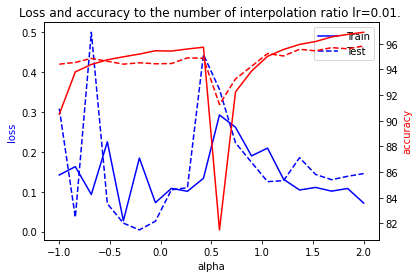

In [30]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(alpa, train_loss_list, 'b', label='Train')
ax1.plot(alpa, test_loss_list, 'b--', label='Test')
ax2.plot(alpa, train_accuracy_list, 'r', label='accuracy')
ax2.plot(alpa, test_accuracy_list, 'r--', label='accuracy')
ax1.set_title('Loss and accuracy to the number of interpolation ratio lr=0.01. ')
ax1.set_xlabel('alpha')
ax1.set_ylabel('loss', color='b')
ax2.set_ylabel('accuracy', color='r')
ax1.legend(loc='upper right')